In [1]:
import pandas as pd
import numpy as np
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline  

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import nltk
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.corpus import stopwords, words
    from nltk import FreqDist

    import gensim
    from gensim import corpora, models, similarities
    import pyLDAvis
    import pyLDAvis.gensim

/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/flow.py:2: DeprecationWarning: Using or importing the ABCs fro

In [2]:
cities = pd.read_csv('cities_geo2_df.csv', index_col=0)

# Reset index
cities = cities.reset_index()
cities.drop(['index'], axis=1, inplace=True)

In [3]:
#cities.head()

In [4]:
# Run once
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('words')

In [5]:
tokenizer = RegexpTokenizer(r'\w+') # retains alphanumeric character
lmtzr = WordNetLemmatizer()
cached_stop_words = stopwords.words("english")

In [6]:
def lemmatize_dropstop_words(text): 
    print(text)
    clear_output(wait=True)
    return [lmtzr.lemmatize(word) for word in text if 
            (len(word)>2) and 
            (lmtzr.lemmatize(word) not in cached_stop_words) and 
            (word in words.words())
            ]

def remove_num(text): 
    return re.sub("\d+", " ", text)

In [7]:
cities = cities.replace(np.nan, '', regex=True)

In [8]:
# Add my stop words from txt file
my_stop_words = np.genfromtxt('my_stop_words.txt',dtype='str', delimiter=', ').tolist()
cached_stop_words.extend(my_stop_words)

In [9]:
# Read
REFILTER_WORDS = False

In [10]:
if REFILTER_WORDS == True:
    cities['See_tokens'] = cities['See'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)

In [11]:
if REFILTER_WORDS == True:
    cities['Do_tokens'] = cities['Do'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)
        
    # Pool tokens
    def pool_tokens(row):
        return row['See_tokens']+row['Do_tokens']

    cities['Pooled_tokens'] = cities.apply(pool_tokens, axis=1)

In [12]:
if REFILTER_WORDS == False:
    cities = pd.read_csv('cities_text_processed_df.csv', index_col = 0)

In [13]:
# If reloaded from .csv file, convert string to list
if type(cities['Pooled_tokens'][0])==str:
    cities['Pooled_tokens'] = cities['Pooled_tokens'].apply(ast.literal_eval)

In [14]:
# Most common words
words = []
for sublist in cities['Pooled_tokens']:
    for item in sublist:
        words.append(item)
        
fdist = FreqDist(words)
fdist.most_common(20)

[('museum', 9558),
 ('park', 7930),
 ('art', 3857),
 ('free', 3827),
 ('old', 3576),
 ('temple', 3433),
 ('well', 3299),
 ('center', 3062),
 ('world', 2996),
 ('town', 2972),
 ('festival', 2790),
 ('road', 2779),
 ('bus', 2682),
 ('river', 2681),
 ('small', 2613),
 ('church', 2584),
 ('walk', 2574),
 ('station', 2569),
 ('local', 2454),
 ('great', 2406)]

In [15]:
# Save cities with final index
cities.to_csv('cities_text_processed_df.csv')

In [16]:
# Join tokens to one string to be compatible w/ sklearn models
def tokens_to_str(tokens):
    return ' '.join(tokens)

cities['Pooled_string'] = cities['Pooled_tokens'].apply(tokens_to_str)

In [17]:
cities.head()

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens,Pooled_string
0,Afghanistan,Herat,Herat is the second largest city in Afghanista...,The Herat International Airport is situated 15...,NaN,"Ghala Ekhteyaradin, Takht Safar, Bagh Milat, ...",Take a shower in the huge subterranean Hammams.,There are several antique shops on the north ...,Herat has a mixture of traditional and modern ...,"Budget[edit] Mowafaq Hotel, northeast corner ...",...,62.189999,927.0,NaN,NaN,NaN,NaN,"['masjid', 'jami', 'bridge', 'shad', 'tomb', '...","['shower', 'huge', 'subterranean']","[masjid, jami, bridge, shad, tomb, gazer, sang...",masjid jami bridge shad tomb gazer sang haft d...
1,Afghanistan,Kabul,Kabul is a very historic city of the region th...,By plane[edit] Kabul International Airport (IA...,Maps of Kabul are available from Afghanistan I...,Bagh-e Babur (Gardens of Babur). The gardens ...,Kabul Wall. A pleasant hike with rewarding vi...,The Share-e Naw area has some shops. The Kab...,The once thriving restaurant scene in Kabul ha...,"Kabul is not a cheap place to stay, principall...",...,69.183334,1808.0,NaN,NaN,NaN,NaN,"['surround', 'tomb', 'emperor', 'wished', 'bur...","['wall', 'pleasant', 'hike', 'rewarding', 'wal...","[surround, tomb, emperor, wished, buried, orig...",surround tomb emperor wished buried originally...
2,Afghanistan,Jalalabad,NaN,Jalalabad is on the major highway that links K...,NaN,The large reservoir near Sarobi. This is loca...,Go fishing along the river side. Go swimming .,Handi Craft Handicraft is one of most famous ...,Pakora go for special “Pakora” Food in Hindu ...,The government hotel Spingar is on the easter...,...,70.449997,573.0,NaN,NaN,NaN,NaN,"['large', 'reservoir', 'way', 'museum', 'relat...","['fishing', 'river', 'swimming']","[large, reservoir, way, museum, related, perio...",large reservoir way museum related period muse...
3,Afghanistan,Kandahar,Kandahār or Qandahār (Pashto: کندهار ) (Persia...,By plane[edit] Kandahar International Airport ...,NaN,"Kandahar Museum, (Western end of the Eidgah ...",NaN,"Afghanistan International Bank (AIB), Kabul Ba...","There are plenty of food choices in Kandahar, ...","Budget[edit] Armani Hotel, (Two miles from c...",...,65.699997,1015.0,NaN,NaN,NaN,NaN,"['museum', 'western', 'important', 'mausoleum'...",[],"[museum, western, important, mausoleum, baba, ...",museum western important mausoleum baba wali b...
4,Afghanistan,Kunduz,NaN,Most visitors will arrive by road from Pol-e K...,"The city is fairly small. The local roads, li...",There's not much for tourists here.,NaN,NaN,The usual Afghan fare - kebab or lamb with ric...,NaN,...,68.860001,394.0,NaN,NaN,NaN,NaN,[],[],[],


# CountVec

In [18]:
# Initialize CountVec
cvec=CountVectorizer(min_df=10)

In [19]:
# CountVec fit to Bag of Words
cvec1 = cvec.fit_transform(cities['Pooled_string'])

In [20]:
# Cosine similarity matrix
cosims_mat = 1-pairwise_distances(cvec1.A, metric="cosine")
cosims_mat

cosims_df = pd.DataFrame(cosims_mat)
cosims_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,1.000000,0.295626,0.193178,0.104627,0.0,0.234216,0.251456,0.163984,0.172033,0.128054,...,0.138657,0.0,0.232751,0.216424,0.0,0.181272,0.042258,0.135459,0.073121,0.168482
1,0.295626,1.000000,0.321922,0.112421,0.0,0.112627,0.360826,0.234524,0.060408,0.097843,...,0.225317,0.0,0.175183,0.200470,0.0,0.207088,0.134535,0.266365,0.114578,0.275858
2,0.193178,0.321922,1.000000,0.079584,0.0,0.049487,0.235406,0.077958,0.000000,0.038961,...,0.146483,0.0,0.102632,0.113531,0.0,0.126789,0.071429,0.181827,0.092698,0.097641
3,0.104627,0.112421,0.079584,1.000000,0.0,0.150096,0.066937,0.045038,0.266815,0.016881,...,0.076163,0.0,0.133407,0.000000,0.0,0.030902,0.139272,0.078784,0.000000,0.015865
4,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


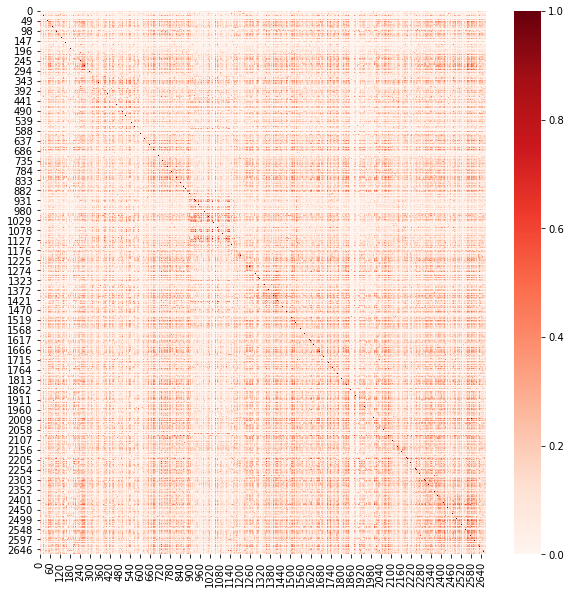

In [22]:
# Visualize cosims matrix

plt.figure(figsize=(10,10))
sns.heatmap(cosims_df.values,cmap='Reds')

In [48]:
# Test output cities given user input

input_city = 'Tokyo'
input_index = [cities[cities['City']==input_city].index]
output_index = cosims_df.iloc[input_index[0][0]].sort_values(ascending = False).head(10)
cities.iloc[output_index.index]

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens,Pooled_string
1410,Japan,Tokyo,"Over 500 years old, the city of Tokyo grew fro...",Luggage delivery Send your bags into town ...,By train and subway[edit] Tokyo has one of the...,"Tokyo has a vast array of sights, but the firs...",A beautiful weekend afternoon is best spent in...,"If it is for sale anywhere in the world, you c...","The sheer quantity, variety and quality of foo...",There are thousands of hotels in the Tokyo are...,...,139.691681,40.0,NaN,NaN,NaN,NaN,"['vast', 'array', 'agenda', 'imperial', 'palac...","['beautiful', 'weekend', 'afternoon', 'best', ...","[vast, array, agenda, imperial, palace, shrine...",vast array agenda imperial palace shrine comme...
1502,South Korea,Seoul,Seoul is the largest city in South Korea as we...,By plane[edit] Incheon Airport[edit] Most visi...,"Traffic jams are all too common in Seoul, so b...",Palaces[edit] As the ancient seat of Korea's r...,There are so many various activities to do 24/...,"Markets[edit] Namdaemun, [127]. The largest t...",This guide uses the following price ranges ...,Budget[edit] Seoul's has two unofficial backpa...,...,126.978300,NaN,Seoul,37.598500,126.978300,Seoul,"['ancient', 'seat', 'royalty', 'major', 'defin...","['various', 'full', 'energy', 'night', 'shoppi...","[ancient, seat, royalty, major, definitely, wo...",ancient seat royalty major definitely worth pa...
353,China,Daan,"In 1884, the Qing dynasty governor of Taiwan, ...",By plane[edit] Taiwan Taoyuan International Ai...,"By metro[edit] Taipei City has a very clean, e...",Taipei has often been skipped by tourists in ...,Hot Springs (溫泉)[edit] Hot springs come in var...,It is often said that L.A. has no center. In ...,Taipei probably has one of the highest densit...,This guide uses the following price ranges ...,...,100.220718,2394.0,NaN,NaN,NaN,NaN,"['hong', 'shanghai', 'look', 'soon', 'vibrant'...","['hot', 'hot', 'various', 'ranging', 'basic', ...","[hong, shanghai, look, soon, vibrant, major, f...",hong shanghai look soon vibrant major full cer...
2127,Taiwan,Taipei,"In 1884, the Qing dynasty governor of Taiwan, ...",By plane[edit] Taiwan Taoyuan International Ai...,"By metro[edit] Taipei City has a very clean, e...",Taipei has often been skipped by tourists in ...,Hot Springs (溫泉)[edit] Hot springs come in var...,It is often said that L.A. has no center. In ...,Taipei probably has one of the highest densit...,This guide uses the following price ranges ...,...,121.525000,NaN,Taipei,25.039167,121.525000,Taipei,"['hong', 'shanghai', 'look', 'soon', 'vibrant'...","['hot', 'hot', 'various', 'ranging', 'basic', ...","[hong, shanghai, look, soon, vibrant, major, f...",hong shanghai look soon vibrant major full cer...
520,China,Taipei,"In 1884, the Qing dynasty governor of Taiwan, ...",By plane[edit] Taiwan Taoyuan International Ai...,"By metro[edit] Taipei City has a very clean, e...",Taipei has often been skipped by tourists in ...,Hot Springs (溫泉)[edit] Hot springs come in var...,It is often said that L.A. has no center. In ...,Taipei probably has one of the highest densit...,This guide uses the following price ranges ...,...,116.791664,41.0,NaN,NaN,NaN,NaN,"['hong', 'shanghai', 'look', 'soon', 'vibrant'...","['hot', 'hot', 'various', 'ranging', 'basic', ...","[hong, shanghai, look, soon, vibrant, major, f...",hong shanghai look soon vibrant major full cer...
808,Germany,Hamburg,It values its status as being as independent a...,By plane[edit] Airport Hamburg-Fuhlsbüttel (IA...,Public transport[edit] Hamburg has a well-deve...,City Centre[edit] Around Mönckebergstraße[edit...,Boat trips[edit] The best way to explore Hambu...,The main shopping area of Hamburg is the Mönck...,Cuisine[edit] Original Hamburg dishes are Bi...,Budget[edit] On the floor[edit] There is a Chu...,...,10.000000,3.0,NaN,NaN,NaN,NaN,"['central', 'railway', 'station', 'main